In [244]:
using DataFrames
using Gadfly
using CSV
using HDF5
using MAT
using Optim
using StatsKit
using Random

#### Regularized Linear Regression and Bias v.s. Variance.

Implement regularized linear regression and use it to study models with different bias-variance properties.

In [245]:
const fpath = "./machine-learning-ex5/ex5/"
const fname = "ex5data1.mat"

"ex5data1.mat"

Dataset contains historical records on the change in the water level, x, and the amount of water flowing out of the dam, y.

In [246]:
# load train, test and validation data
file = matopen(fpath * fname)
names(file)
Xtrain = read(file, "X")
ytrain = read(file, "y")
Xval = read(file, "Xval")
yval = read(file, "yval")
Xtest = read(file, "Xtest")
ytest = read(file, "ytest");

In [247]:
size(Xtrain), size(Xval), size(Xtest)

((12, 1), (21, 1), (21, 1))

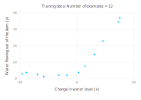

In [248]:
# Plot the training data
plot(x = Xtrain, y = ytrain, 
    Geom.point,
    Guide.xlabel("Change in water level (x)"),
    Guide.ylabel("Water flowing out of the dam (y)"),
    Guide.title("Training data: Number of examples = $(size(Xtrain)[1])")
)

##### Regularized linear regression cost function and gradient

In [249]:
"Cost function. Returns two pointers to functions for cost and gradient"
function linearRegCostFunction(Xmat, y, λ = 0)

    m = length(y)
    return (weights::Array) -> begin
        l2_penalty = (λ/2m) * (weights[2:end]'weights[2:end])
        errors = Xmat * weights'
        sum_sqrd_errs = sum((errors - y).^2)
        (1/2m) * sum_sqrd_errs + l2_penalty
        end, (weights::Array) -> begin
                penalty = hcat(0.0, (λ/m)* weights[:, 2:end])
                errors = Xmat * weights' - y
                (errors'Xmat)/m + penalty
            end
end

linearRegCostFunction

In [250]:
# Single expression function 
"Add a vector of ones to design matrix"
addconstant(Xmat) = hcat(ones(size(Xmat)[1]), Xmat)

addconstant

In [251]:
# Test linearRegCostFunction using theta initialized at [1; 1]. You should see an output of 303.993
# and a gradient of [-15.30; 598.250]
λ = 1
initial_θ = [1 1]
cost, grad = linearRegCostFunction(addconstant(Xtrain), ytrain, λ);
println("Cost at theta = [1 1]: $(round(cost(initial_θ), digits = 3))")
println("Gradient at theta = [1 ; 1]: $(grad(initial_θ))")

Cost at theta = [1 1]: 303.993
Gradient at theta = [1 ; 1]: [-15.303 598.251]


#### Fitting linear regression

In [252]:
"Optimize the cost function"
function trainLinearReg(Xmat, ymat, λ)
    cost, gradient = linearRegCostFunction(Xmat, ymat, λ)
    initial_θ = zeros(Float64, (1, size(Xmat)[2]))
    optimize(cost, gradient, initial_θ, ConjugateGradient(); inplace = false)
    #optimize(cost, gradient, initial_θ; inplace = false)
end

trainLinearReg

In [253]:
# compute optimal values. lambda = 0
lambda = 0
train_res = trainLinearReg(addconstant(Xtrain), ytrain, lambda)
train_coefs = Optim.minimizer(train_res)
train_cost = Optim.minimum(train_res)
println("θ values from optimization (λ = 0): $train_coefs with cost: $train_cost")

θ values from optimization (λ = 0): [13.0879 0.367779] with cost: 22.373906495108915


##### Plot best fit line. The best fit line tells us that the model is not a good fit to the data because the data has a non-linear pattern.

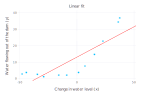

In [254]:
plot(x = Xtrain, y = ytrain, 
    Geom.point,
    intercept = [train_coefs[1]], slope = [train_coefs[2]],
    Geom.abline(color = "red"),
    Guide.xlabel("Change in water level (x)"),
    Guide.ylabel("Water flowing out of the dam (y)"),
    Guide.title("Linear fit")
)

#### Bias-variance
An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data. In this part of the exercise, you will plot training and test errors on a learning curve to diagnose bias-variance problems.

A learning curve plots training and cross validation error as a function of training set size. To plot the learning curve, we need a training and cross validation set error for different training set sizes. To obtain different training set sizes, you should use different subsets of the original training set X. Specifically, for a training set size of i, you should use the first i examples (i.e., X(1:i,:) and y(1:i)).

In [255]:
"Generate learning curve"
function learningCurve(Xmat, ymat, Xvalmat, yvalmat, λ)
    cost_train = Array{Float64, 1}(undef, length(ymat))
    cost_valid = Array{Float64, 1}(undef, length(ymat))

    for m in 1:1:size(Xmat)[1] # at each iteration, the number of training examples increases by 1
        res = trainLinearReg(Xmat[1:m,:], ymat[1:m], λ)
        cost_train[m] = Optim.minimum(res)
        cost, gradient = linearRegCostFunction(Xvalmat, yvalmat, λ)
        cost_valid[m] = cost(Optim.minimizer(res))
    end
    return cost_train, cost_valid
end

learningCurve

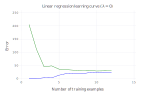

In [256]:
# Plot learning curve
lambda = 0
error_train, error_val = learningCurve(addconstant(Xtrain), ytrain,
                                        addconstant(Xval), yval, lambda)

line1 = layer(x = collect(1:1:12), y = error_train, Geom.line, Theme(default_color="blue"))
line2 = layer(x = collect(1:1:12), y = error_val, Geom.line, Theme(default_color="green"))
plot(line1, line2,
    Guide.xlabel("Number of training examples"),
    Guide.ylabel("Error"),
    Guide.title("Linear regression learning curve (λ = $lambda)")
)

Both the train error and cross validation error are high when the number of training examples is increased. This reflects a high bias problem in the model – the linear regression model is too simple and is unable to fit our dataset well.

#### Polynomial Features

The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias). In this part of the exercise, you will address this problem by adding more features (higher powers of feature x).

Add more features using the higher powers of existing feature in the dataset. When a training set X of size m × 1 is passed into the function, the function returns a m×p matrix X where column 1 holds the original values of X, column 2 holds the values of X.^2, column 3 holds the values of X.^3 and so on.

In [257]:
# single expression function

"Generate polynomial features of degree p"
polyFeatures(Xmat, p) = Xmat.^((1:p)') # the vector is broadcast against each degree up to p

polyFeatures

normalize_features(X) returns a normalized version of X where the mean value of each feature is 0 and the standard deviation is 1. This is often a good preprocessing step to do when working with learning algorithms.

In [258]:
"Normalizes columns of matrix Xmat. Returns normalized matrix along with means and sd for each feature."
function normalize_features(Xmat)::Tuple{Array, Array}
    norms = Array{Float64, 2}(undef, size(Xmat)) # store normalized values
    stats = Array{Float64, 2}(undef, (size(Xmat)[2], 2)) # save means and sds

    for idx in 1:1:size(Xmat)[2]
        mean_idx = mean(Xmat[:, idx])
        sd_idx = std(Xmat[:, idx])
        norms[:, idx] = (Xmat[:, idx] .- mean_idx) ./ std(Xmat[:, idx])
        stats[idx, 1] = mean_idx
        stats[idx, 2] = sd_idx
    end
    return norms, stats
end

normalize_features

In [259]:
poly_deg = 6 # used degree 6 polynomial to get Figure 4 on page 8
Xtrain_poly = polyFeatures(Xtrain, poly_deg);
Xtrain_poly_norm, Xtrain_poly_stats = normalize_features(Xtrain_poly);
size(Xtrain_poly_norm)

(12, 6)

In [260]:
Xtrain_poly_norm # normalized training data

12×6 Array{Float64,2}:
 -0.362141  -0.755087     0.182226  -0.70619     0.306618   -0.590878 
 -0.803205   0.00125825  -0.247937  -0.327023    0.0933963  -0.435818 
  1.37747    0.584827     1.24977    0.245312    0.97836    -0.0121557
  1.42094    0.706647     1.35985    0.395534    1.10616     0.125637 
 -1.43415    1.854       -2.03716    2.33143    -2.41154     2.60221  
 -0.128687  -0.975969     0.251385  -0.739687    0.316953   -0.594997 
  0.680582  -0.780029     0.340656  -0.711721    0.326509   -0.59179  
 -0.988534   0.451358    -0.601282   0.0929171  -0.218473   -0.141608 
  0.216076  -1.07499      0.266275  -0.743369    0.317561   -0.595129 
 -1.3115     1.42281     -1.54812    1.4934     -1.51591     1.38865  
  0.403777  -1.01501      0.273379  -0.741977    0.317742   -0.595098 
  0.929375  -0.419808     0.510968  -0.588624    0.382616   -0.55903  

In [261]:
# check means and sds of normalized data. Should be zeros and ones, respectively.
println(map(c -> mean(Xtrain_poly_norm[:, c]), 1:poly_deg)) 
println(map(c -> std(Xtrain_poly_norm[:, c]), 1:poly_deg))

[-6.4763e-17, 2.35922e-16, 5.55112e-17, -4.62593e-17, 7.86408e-17, 6.4763e-17]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [262]:
μ = Xtrain_poly_stats[:,1] 
σ = Xtrain_poly_stats[:,2]; 

In [263]:
μ # means of individual features

6-element Array{Float64,1}:
     -5.085426348834809   
    848.9048336819202     
 -12829.017310853851      
      1.289677885732049e6 
     -2.9831459159614608e7
      2.2933030137889485e9

In [264]:
σ #sds of individual features

6-element Array{Float64,1}:
    29.964402016680886   
   787.8891032373806     
 48189.6178402862        
     1.7349043075558976e6
     9.393920401041684e7 
     3.8534537254975996e9

In [265]:
# normalize validation set
Xvalid_poly = polyFeatures(Xval, poly_deg)
Xvalid_poly_norm = (Xvalid_poly .- μ') ./ σ';
size(Xvalid_poly_norm)

(21, 6)

In [266]:
# normalize test set
Xtest_poly = polyFeatures(Xtest, poly_deg)
Xtest_poly_norm = (Xtest_poly .- μ') ./ σ';
size(Xtest_poly_norm)

(21, 6)

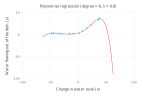

In [267]:
# compute optimal values. use default optimize
lambda = 0.0
train_poly_res = trainLinearReg(addconstant(Xtrain_poly_norm), ytrain, lambda)
train_poly_coefs = Optim.minimizer(train_poly_res) # optimal θs
#train_poly_fitted = addconstant(Xtrain_poly_norm) * train_poly_coefs'; #fitted values 

# create a grid of X values and normalize
Xgrid = collect(minimum(Xtrain) - 15:0.05:maximum(Xtrain) + 25)
Xgrid_poly = polyFeatures(Xgrid, poly_deg)
Xgrid_poly_norm = (Xgrid_poly .- μ') ./ σ'
fitted_Xgrid = addconstant(Xgrid_poly_norm) * train_poly_coefs';

# plot outcomes and fitted values 
line1 = layer(x = Xtrain, y = ytrain, Geom.point)
line2 = layer(x = Xgrid, y = fitted_Xgrid, Geom.line, Theme(default_color="red"))
plot(line1, line2,
    Guide.xlabel("Change in water level (x)"),
    Guide.ylabel("Water flowing out of the dam (y)"),
    Guide.title("Polynomial regression (degree = 6, λ = $lambda)")
    )

The polynomial fit is able to follow the data very well resulting in low training error. However, the fit is very complex and even drops off at the extremes suggesting that the model is overfitting the training data and will not generalize well. 

Examining the learning curve below shows the same effect where the training error is low but the cross validation error is high. There is a gap between the training and cross validation errors, indicating a high variance problem.

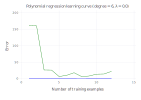

In [268]:
# Plot learning curve for λ = 0.0
lambda = 0.0
error_poly_train, error_poly_val = learningCurve(addconstant(Xtrain_poly_norm), ytrain,
                                        addconstant(Xvalid_poly_norm), yval, lambda)

line1 = layer(x = collect(1:1:12), y = error_poly_train,
                                        Geom.line, Theme(default_color="blue"))
line2 = layer(x = collect(1:1:12), y = error_poly_val,
                                        Geom.line, Theme(default_color="green"))
plot(line1, line2,
    Guide.xlabel("Number of training examples"),
    Guide.ylabel("Error"),
    Guide.title("Polynomial regression learning curve (degree = 6, λ = $lambda)")
)

#### Adjusting the regularization parameter

One way to combat the overfitting (high-variance) problem is to add regularization to the model. In this section, we will try different λ parameters to see how regularization can lead to a better model. Regularization affects the bias-variance of the regularized polynomial regression.

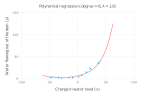

In [269]:
# generate polynomial fit for data with λ = 1.0
lambda = 1.0
train_poly_res = trainLinearReg(addconstant(Xtrain_poly_norm), ytrain, lambda)
train_poly_coefs = Optim.minimizer(train_poly_res) # optimal θs
#train_poly_fitted = addconstant(Xtrain_poly_norm) * train_poly_coefs'; #fitted values 

# create a grid of X values and normalize
Xgrid = collect(minimum(Xtrain) - 15:0.05:maximum(Xtrain) + 25)
Xgrid_poly = polyFeatures(Xgrid, poly_deg)
Xgrid_poly_norm = (Xgrid_poly .- μ') ./ σ'
fitted_Xgrid = addconstant(Xgrid_poly_norm) * train_poly_coefs';

# plot outcomes and fitted values 
line1 = layer(x = Xtrain, y = ytrain, Geom.point)
line2 = layer(x = Xgrid, y = fitted_Xgrid, Geom.line, Theme(default_color="red"))
plot(line1, line2,
    Guide.xlabel("Change in water level (x)"),
    Guide.ylabel("Water flowing out of the dam (y)"),
    Guide.title("Polynomial regression (degree = 6, λ = $lambda)")
    )

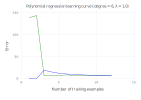

In [270]:
# Plot learning curve for λ = 1.0
lambda = 1.0
error_poly_train, error_poly_val = learningCurve(addconstant(Xtrain_poly_norm), ytrain,
                                        addconstant(Xvalid_poly_norm), yval, lambda)

line1 = layer(x = collect(1:1:12), y = error_poly_train,
                                        Geom.line, Theme(default_color="blue"))
line2 = layer(x = collect(1:1:12), y = error_poly_val,
                                        Geom.line, Theme(default_color="green"))
plot(line1, line2,
    Guide.xlabel("Number of training examples"),
    Guide.ylabel("Error"),
    Guide.title("Polynomial regression learning curve (degree = 6, λ = $lambda)")
)

The figures above show that the polynomial fit follows the data trend well and both the cross validation and training error converge to a relatively low value (learning curve). This shows the λ = 1 regularized polynomial regression model does not have the high- bias or high-variance problems. In effect, it achieves a good trade-off between bias and variance. (Unclear why the learning curve differs slightly from Figure 7 on page 11.)

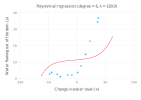

In [271]:
# generate polynomial fit for data with λ = 100.0
lambda = 100.0
train_poly_res = trainLinearReg(addconstant(Xtrain_poly_norm), ytrain, lambda)
train_poly_coefs = Optim.minimizer(train_poly_res) # optimal θs
#train_poly_fitted = addconstant(Xtrain_poly_norm) * train_poly_coefs'; #fitted values 

# create a grid of X values and normalize
Xgrid = collect(minimum(Xtrain) - 15:0.05:maximum(Xtrain) + 25)
Xgrid_poly = polyFeatures(Xgrid, poly_deg)
Xgrid_poly_norm = (Xgrid_poly .- μ') ./ σ'
fitted_Xgrid = addconstant(Xgrid_poly_norm) * train_poly_coefs';

# plot outcomes and fitted values 
line1 = layer(x = Xtrain, y = ytrain, Geom.point)
line2 = layer(x = Xgrid, y = fitted_Xgrid, Geom.line, Theme(default_color="red"))
plot(line1, line2,
    Guide.xlabel("Change in water level (x)"),
    Guide.ylabel("Water flowing out of the dam (y)"),
    Guide.title("Polynomial regression (degree = 6, λ = $lambda)")
    )

For λ = 100, we can see that the polynomial fit that does not follow the data well. In this case, there is too much regularization and the model is unable to fit the training data.

#### Selecting λ using a cross validation set

The value of λ can significantly affect the results of regularized polynomial regression on the training and cross validation set. In particular, a model without regularization (λ = 0) fits the training set well, but does not generalize. Conversely, a model with too much regularization (λ = 100) does not fit the training set and testing set well. A good choice of λ (e.g., λ = 1) can provide a good fit to the data.

In the following section, an automated method to select λ is implemented; specifically, a cross validation set is used to evaluate the λ. The best λ is selected and is used to evaluate the model on a test set to estimate how well it will perform on unseen data.

In [272]:
# change lambda (increase) to address problem with variance
# train the model using different values of λ and compute the training error and the cross validation error
lambda_vals = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10];

In [273]:
"returns a pointer to a function that calculates training error and cross validation error for λ"
function validationCurve(Xmat, ymat, Xvalmat, yvalmat)
    return (λ::Float64) -> begin
        results = trainLinearReg(Xmat, ymat, λ)
        coefs_train = Optim.minimizer(results)
        cost_train = Optim.minimum(results)
        cost_val, grd_val = linearRegCostFunction(Xvalmat, yvalmat, λ)
        cost_train, cost_val(coefs_train)
    end
end

validationCurve

In [274]:
# errors is a function which can be called with λ as the argument
errors = validationCurve(addconstant(Xtrain_poly_norm), ytrain,
                addconstant(Xvalid_poly_norm), yval)

# broadcast lambda values as arguments to errors; 
# returns array of tuples with training errors and cross validation errors for each λ
errors_λ = errors.(lambda_vals); 
errors_λ

10-element Array{Tuple{Float64,Float64},1}:
 (0.19805294312764055, 22.119418879268185)
 (0.2221742942565615, 19.6498788199903)   
 (0.265232921539187, 17.088951247494233)  
 (0.39217511230694113, 13.595923872538792)
 (0.6800559979478824, 10.390864492255208) 
 (1.4558656116766007, 7.352472696960391)  
 (3.1156207979797883, 5.939529870409503)  
 (7.338821702429186, 6.9221947474989705)  
 (16.19665480542181, 10.077697309838912)  
 (34.134385769036236, 21.85879868442177)  

In [275]:
# see https://discourse.julialang.org/t/array-of-tuples/11435/9
# broadcast getindex function
train_errors = getindex.(errors_λ, 1)
valid_errors = getindex.(errors_λ, 2);


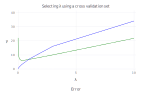

In [276]:
line1 = layer(x = lambda_vals, y = train_errors,
                                Geom.line, Theme(default_color="blue"))
line2 = layer(x = lambda_vals, y = valid_errors,
                                Geom.line, Theme(default_color="green"))
plot(line1, line2,
    Guide.xlabel("λ"),
    Guide.xlabel("Error"),
    Guide.title("Selecting λ using a cross validation set")
    )

Above figure differs from the Figure 9 shown in the assignment.

In [277]:
best_lambda = lambda_vals[argmin(valid_errors)] # find best value of λ

0.3

In [278]:
# Calculate test error for best_lambda
best_res = trainLinearReg(addconstant(Xtrain_poly_norm), ytrain, best_lambda)
best_coefs = Optim.minimizer(best_res)
best_coefs

1×7 Array{Float64,2}:
 11.2176  10.6032  7.1993  2.79817  1.28613  0.898549  -0.472291

#### Computing test set error

In [279]:
# use optimal coefs to calculate test error
cost_test, grd_test = linearRegCostFunction(addconstant(Xtest_poly_norm), ytest, best_lambda)
println("Test error using the best value of λ (0.3) is $(round(cost_test(best_coefs), digits = 3))")

Test error using the best value of λ (0.3) is 5.737


#### Plotting learning curves with randomly selected examples

In practice, especially for small training sets, when you plot learning curves to debug your algorithms, it is often helpful to average across multiple sets of randomly selected examples to determine the training error and cross validation error.

Concretely, to determine the training error and cross validation error for i examples, you should first randomly select i examples from the training set and i examples from the cross validation set. You will then learn the parameters θ using the randomly chosen training set and evaluate the parameters θ on the randomly chosen training set and cross validation set. The above steps should then be repeated multiple times (say 50) and the averaged error should be used to determine the training error and cross validation error for i examples.

In [280]:
"Returns pointer to a function that averages training and validation errors for 50 draws of random examples of a given size"
function learningCurveRandom(Xmat, ymat, Xvalmat, yvalmat, λ = 0)
    draws = 50
    return (num_ex_sampled::Int64) -> begin
        cum_cost_train = 0
        cum_cost_valid = 0
        rng = MersenneTwister(1234)

        for draw in 1:draws
            num_ex_Xmat = size(Xmat, 1)
            ex_train_sampled = rand(rng, 1:num_ex_Xmat, num_ex_sampled)

            res_sampled = trainLinearReg(Xmat[ex_train_sampled, :],
                                            ymat[ex_train_sampled], λ)
            coefs_sampled = Optim.minimizer(res_sampled)
            cost_sampled = Optim.minimum(res_sampled)
            cum_cost_train += cost_sampled

            num_ex_Xvalmat = size(Xvalmat, 1)
            ex_val_sampled = rand(rng, 1:num_ex_Xvalmat, num_ex_sampled)
            cost_val, grd_val = linearRegCostFunction(Xvalmat[ex_val_sampled, :],
                                                        yvalmat[ex_val_sampled], λ)
            cum_cost_valid += cost_val(coefs_sampled)
        end # for loop
        cum_cost_train/draws, cum_cost_valid/draws
    end # begin
end # function

learningCurveRandom

In [281]:
# learning curve for polynomial regression with λ = 0.01
lambda = 0.01
cv_random = learningCurveRandom(addconstant(Xtrain_poly_norm), ytrain,
                    addconstant(Xvalid_poly_norm), yval, lambda)
errors_random = map(nexamples -> cv_random(nexamples), 1:12); #call cv_random with different number of examples
errors_random

12-element Array{Tuple{Float64,Float64},1}:
 (5.527739484168303e-15, 191.8230493165982)
 (0.1759509525587027, 93.96214140049125)   
 (0.22680820386927267, 57.05584562042866)  
 (0.2620792436250021, 35.07285454090572)   
 (0.23219169583024205, 21.04417982973374)  
 (0.25380713452363785, 28.224754221437912) 
 (0.2661222292442533, 24.030272103882258)  
 (0.2494251599709781, 16.208291696019774)  
 (0.2817173947887078, 14.935781976005412)  
 (0.2710441504075645, 24.31692903876932)   
 (0.2626954379732575, 17.412830582013818)  
 (0.2587040011819532, 16.383571991044658)  

In [282]:
train_random_errs = getindex.(errors_random, 1)
valid_random_errs = getindex.(errors_random, 2);

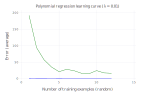

In [283]:
#plot the learning curve for polynomial regression with λ = 0.01
line1 = layer(x = 1:12, y = train_random_errs,
                                Geom.line, Theme(default_color="blue"))
line2 = layer(x = 1:12, y = valid_random_errs,
                                Geom.line, Theme(default_color="green"))
plot(line1, line2,
    Guide.xlabel("Number of training examples (random)"),
    Guide.ylabel("Error (average)"),
    Guide.title("Polynomial regression learning curve (λ = $lambda)"))

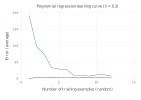

In [284]:
# learning curve for polynomial regression with λ = 0.3
lambda = 0.3
cv_random = learningCurveRandom(addconstant(Xtrain_poly_norm), ytrain,
                    addconstant(Xvalid_poly_norm), yval, lambda)
errors_random = map(nexamples -> cv_random(nexamples), 1:12); #call cv_random with different number of examples

train_random_errs = getindex.(errors_random, 1)
valid_random_errs = getindex.(errors_random, 2);

line1 = layer(x = 1:12, y = train_random_errs,
                                Geom.line, Theme(default_color="blue"))
line2 = layer(x = 1:12, y = valid_random_errs,
                                Geom.line, Theme(default_color="green"))
plot(line1, line2,
    Guide.xlabel("Number of training examples (random)"),
    Guide.ylabel("Error (average)"),
    Guide.title("Polynomial regression learning curve (λ = $lambda)"))

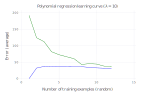

In [285]:
# learning curve for polynomial regression with λ = 10
lambda = 10
cv_random = learningCurveRandom(addconstant(Xtrain_poly_norm), ytrain,
                    addconstant(Xvalid_poly_norm), yval, lambda)
errors_random = map(nexamples -> cv_random(nexamples), 1:12); #call cv_random with different number of examples

train_random_errs = getindex.(errors_random, 1)
valid_random_errs = getindex.(errors_random, 2);

line1 = layer(x = 1:12, y = train_random_errs,
                                Geom.line, Theme(default_color="blue"))
line2 = layer(x = 1:12, y = valid_random_errs,
                                Geom.line, Theme(default_color="green"))
plot(line1, line2,
    Guide.xlabel("Number of training examples (random)"),
    Guide.ylabel("Error (average)"),
    Guide.title("Polynomial regression learning curve (λ = $lambda)"))

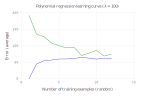

In [286]:
# learning curve for polynomial regression with λ = 100
lambda = 100
cv_random = learningCurveRandom(addconstant(Xtrain_poly_norm), ytrain,
                    addconstant(Xvalid_poly_norm), yval, lambda)
errors_random = map(nexamples -> cv_random(nexamples), 1:12); #call cv_random with different number of examples

train_random_errs = getindex.(errors_random, 1)
valid_random_errs = getindex.(errors_random, 2);

line1 = layer(x = 1:12, y = train_random_errs,
                                Geom.line, Theme(default_color="blue"))
line2 = layer(x = 1:12, y = valid_random_errs,
                                Geom.line, Theme(default_color="green"))
plot(line1, line2,
    Guide.xlabel("Number of training examples (random)"),
    Guide.ylabel("Error (average)"),
    Guide.title("Polynomial regression learning curve (λ = $lambda)"))